# Лабораторная работа по глубокому обучению \#1 

In [275]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Перед началом работы, почистим датасет от пустых файлов

In [276]:
for root, dirs, files in os.walk(os.path.abspath(r'data/hotdog/')):
    for file in files:
        path = os.path.join(root, file)
        if os.path.getsize(path) == 0:
            os.remove(path)

Решаем задачу бинарной классификации. Два класса - хотдог и не-хотдог.

In [277]:
classes = ('not_hotdog','hotdog')

## Часть 1. Использование классического машинного обучения

Для организации получения данных будем использовать `DataLoader` из `pytorch`. 

Каждое изображение из датасета будем масштабировать к размеру `244 x 244 px`.

In [4]:
resize_and_crop = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

Объявляем датасет с указанием трансформации, приведенной выше

In [278]:
hotdog_dataset = datasets.ImageFolder(root='data/hotdog/train/', transform=resize_and_crop)

Разделяем датасет на train/validation в пропорции 80/20 и объявляем генераторы изображений, которые будут отдавать по одной случайной картинке из датасета

In [432]:
dataset_size = len(hotdog_dataset.imgs)
train_size = int(dataset_size * 0.8)
train, test = torch.utils.data.dataset.random_split(hotdog_dataset, (train_size, dataset_size - train_size))

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

torch.Size([1, 3, 224, 224])


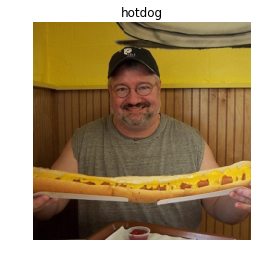

In [453]:
img, l = iter(train_loader).next()
print(img.size())
plt.imshow(np.transpose(img[0], (1, 2, 0)))
plt.title(classes[l])
plt.axis('off')
plt.show()

In [144]:
def get_dataset(loader):
    """
    Функция загружает все изображения из `loader` и возвращает два np.array.
    images - изображения. Каждое изображение "вытянуто" в вектор.
    labels - метки
    """
    images, labels = [], []
    for img, l in loader:
        images.append(np.reshape(img.numpy(), -1)) # Все 3 RGB слоя изображения представляем в виде единого вектора
        labels.append(l.numpy())
    images, labels = np.array(images), np.reshape(labels, -1)
    return images, labels

Формируем train и validation датасеты, пригодные для обучения моделей scikit-learn

In [145]:
train_images, train_labels = get_dataset(train_loader)
val_images, val_labels = get_dataset(val_loader)

### RandomForest

In [146]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(train_images, train_labels)
print('RandomForest error = {:.2f}'.format(1 - rf.score(val_images, val_labels)))

RandomForest error = 0.16


### SVM

In [147]:
svc = SVC()
svc.fit(train_images, train_labels)
print('SVC error = {:.2f}'.format(1 - svc.score(val_images, val_labels)))

SVC error = 0.18


### Gradient Boosting Trees

In [133]:
gbt = GradientBoostingClassifier()
gbt.fit(train_images, train_labels)
print('Gradient Boosting Trees error = {:.2f}'.format(1 - gbt.score(val_images, val_labels)))

Gradient Boosting Trees error = 0.24


Как показывают результаты, классические алгоритмы справляются с задачей бинарной классфикации по интенсивности пикселей. (С оговорками, что не были подобраны лучшие гиперпараметры алгоритмов для данной задачи)

Однако данный результат можно улучшить.

## Часть 2. Использование простой сверточной сети для классификации

Далее, в ходе работы, будут обучаться нейронные сети. Флаг `USE_GPU` включает использование видеокарты при обучении. Также можно выбрать на каком девайсе будет обучаться сеть.

In [90]:
USE_GPU = True

if USE_GPU:
    device = torch.device("cuda:3")

Будем подавать на вход сети не одно изображение, а батчами по 4. Каждое изображение содержит 3 слоя размером `224x224`. 

In [91]:
batch_size = 4

hotdog_dataset = datasets.ImageFolder(root='data/hotdog/train/', transform=resize_and_crop)

dataset_size = len(hotdog_dataset.imgs)
train_size = int(dataset_size * 0.8)
train, test = torch.utils.data.dataset.random_split(hotdog_dataset, (train_size, dataset_size - train_size))

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

torch.Size([4, 3, 224, 224])
classes: not_hotdog hotdog not_hotdog hotdog


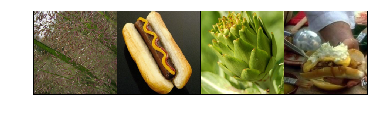

In [78]:
images, labels = iter(train_loader).next()
print(images.size())
print('classes:', ' '.join([classes[i] for i in labels]))
images = torchvision.utils.make_grid(images).numpy()
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis('off')
plt.show()

In [79]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 9, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(9, 18, 3)
        self.conv3 = nn.Conv2d(18, 26, 3)
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(26 ** 3, 64)
        self.fc2 = torch.nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        x = x.view(-1, 26 ** 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [80]:
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if USE_GPU:
    criterion = criterion.cuda()
    net = net.to(device)

In [124]:
def eval_epoch(net, loader, optimizer, criterion, is_train=True):
    if is_train:
        net.train()
    else:
        net.eval()
    running_loss = 0.0
    with torch.set_grad_enabled(is_train):
        for i, data in enumerate(loader):
            inputs, labels = data
            if USE_GPU: inputs, labels = inputs.to(device), labels.to(device)
            if is_train: optimizer.zero_grad()
            outputs = F.softmax(net(inputs), dim=1)
            loss = criterion(outputs, labels)
            if is_train:
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
        return running_loss / (i + 1)

In [82]:
train_loss = []
val_loss = []
for epoch in range(20):
    train_loss.append(eval_epoch(net, train_loader, optimizer, criterion, is_train=True))
    val_loss.append(eval_epoch(net, val_loader, optimizer, criterion, is_train=False))
    print('#{} train: {:.3f} val: {:.3f}'.format(epoch, train_loss[-1], val_loss[-1]))
print('Finished Training')

#0 train: 0.683 val: 0.679
#1 train: 0.667 val: 0.654
#2 train: 0.585 val: 0.567
#3 train: 0.525 val: 0.535
#4 train: 0.522 val: 0.530
#5 train: 0.514 val: 0.546
#6 train: 0.500 val: 0.526
#7 train: 0.505 val: 0.537
#8 train: 0.503 val: 0.532
#9 train: 0.494 val: 0.527
#10 train: 0.494 val: 0.515
#11 train: 0.491 val: 0.523
#12 train: 0.485 val: 0.517
#13 train: 0.483 val: 0.537
#14 train: 0.483 val: 0.524
#15 train: 0.472 val: 0.521
#16 train: 0.468 val: 0.530
#17 train: 0.467 val: 0.525
#18 train: 0.468 val: 0.522
#19 train: 0.464 val: 0.523
Finished Training


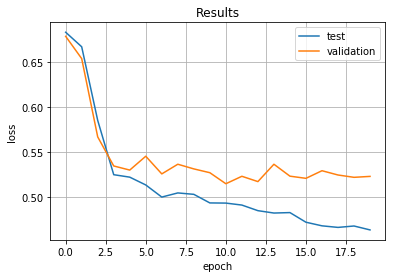

In [83]:
fig, ax = plt.subplots(1,1)
ax.plot(train_loss, label='test')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Results')
ax.grid()
ax.legend()
plt.show()

In [84]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        if USE_GPU:
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Error of the network on validation: {:.2f}'.format(100 * correct / total))

Error of the network on validation: 78.21


## Часть 3. Использование сети, предобученной на ImageNet

Попробуем использовать в качестве фич для классического алгоритма машинного обучения (в нашем случае SVM) фичи, получаемые сетью VGG16 на предпоследнем полносвязном слое. 

Будем использовать сеть, предобученную на датасете ImageNet. Переопределим сеть:

In [92]:
class VGG16_2(nn.Module):
    def __init__(self):
        super(VGG16_2, self).__init__()
        # Берем все слои сети
        layers = list(torchvision.models.vgg16(pretrained=True).children())
        self.features = nn.Sequential(*layers[0])
        self.classifier = nn.Sequential(*layers[1][:-1]) # Выбрасываем последний слой 
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7) # Вытягиваем вектор для полносвязного слоя
        x = self.classifier(x)
        return x

In [93]:
net = VGG16_2()
if USE_GPU:
    net = net.to(device)

In [94]:
def get_data(net, loader):
    """
    Метод для превращения всех картинок в выходы определенной сети
    """
    vectors, labels = [], [] 
    for images_batch, labels_batch in loader:
        if USE_GPU:
            images_batch = images_batch.to(device)
            vectors.append(net(images_batch).detach().cpu().numpy())
        else:
            vectors.append(net(images_batch).detach().numpy())
        labels.append(labels_batch.numpy())
    return np.concatenate(vectors), np.concatenate(labels)

Получаем наши датасеты с фичами, сгенерированными сетью

In [95]:
train_vectors, train_labels = get_data(net, train_loader)
val_vectors, val_labels = get_data(net, val_loader)

Обучаем SVM

In [96]:
svc = SVC(C=10)
svc.fit(train_vectors, train_labels)
print('VGG16_SVC error = {:.2f}'.format(1 - svc.score(val_vectors, val_labels)))

VGG16_SVC error = 0.04


Ошибка получилась гораздо ниже и фактически приблизилась к идеальному классификатору

## Часть 4. Попытка улучшить результат

Попробуем дообучить сеть VGG16 для нашего конкретного случая.

Будем аугментировать данные поступающие на вход сети. Т.е. случайным образом изменять параметры изображения или наклонять и отражать. 

In [237]:
augmentation_resize_and_crop = transforms.Compose([
    torchvision.transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.RandomAffine((0, 360))
    ]),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

hotdog_dataset = datasets.ImageFolder(root='data/hotdog/train/', 
                                      transform=augmentation_resize_and_crop)

In [238]:
batch_size = 4

dataset_size = len(hotdog_dataset.imgs)
train_size = int(dataset_size * 0.8)
train, test = torch.utils.data.dataset.random_split(
    hotdog_dataset, (train_size, dataset_size - train_size))

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

torch.Size([4, 3, 224, 224])
classes: hotdog hotdog not_hotdog hotdog


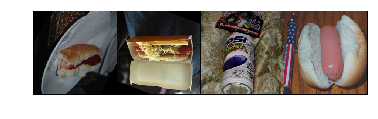

In [239]:
images, labels = iter(train_loader).next()
print(images.size())
print('classes:', ' '.join([classes[i] for i in labels]))

images = torchvision.utils.make_grid(images).numpy()
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis('off')
plt.show()

Кроме того, будем использовать не простую VGG16, а ее модификацию с batch normalization

In [240]:
class VGG16_bn_2(nn.Module):
    def __init__(self):
        super(VGG16_bn_2, self).__init__()
        layers = list(torchvision.models.vgg16_bn(pretrained=True).children())
        self.features = nn.Sequential(*layers[0])
        self.classifier = nn.Sequential(*layers[1][:-1])
        self.fc = nn.Linear(4096, 2) # Для обучения добавим дополнительный финальный слой
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.classifier(x)
        x = self.fc(x)
        return x

In [241]:
net = VGG16_bn_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters())

if USE_GPU:
    criterion = criterion.cuda()
    net = net.to(device)

In [242]:
train_loss = []
val_loss = []
for epoch in range(20):
    train_loss.append(eval_epoch(net, train_loader, optimizer, criterion, is_train=True))
    val_loss.append(eval_epoch(net, val_loader, optimizer, criterion, is_train=False))
    print('#{} train: {:.3f} val: {:.3f}'.format(epoch, train_loss[-1], val_loss[-1]))
print('Finished Training')

#0 train: 0.446 val: 0.385
#1 train: 0.395 val: 0.381
#2 train: 0.382 val: 0.406
#3 train: 0.384 val: 0.401
#4 train: 0.362 val: 0.364
#5 train: 0.356 val: 0.389
#6 train: 0.363 val: 0.373
#7 train: 0.361 val: 0.357
#8 train: 0.356 val: 0.364
#9 train: 0.348 val: 0.404
#10 train: 0.349 val: 0.379
#11 train: 0.346 val: 0.384
#12 train: 0.349 val: 0.376
#13 train: 0.338 val: 0.376
#14 train: 0.342 val: 0.369
#15 train: 0.346 val: 0.376
#16 train: 0.344 val: 0.374
#17 train: 0.333 val: 0.367
#18 train: 0.332 val: 0.365
#19 train: 0.339 val: 0.354
Finished Training


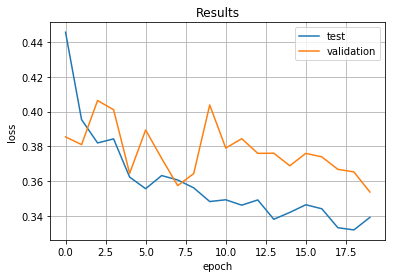

In [243]:
fig, ax = plt.subplots(1,1)
ax.plot(train_loss, label='test')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Results')
ax.grid()
ax.legend()
plt.show()

In [244]:
class FeatureNet(nn.Module):
    def __init__(self, trained_net):
        super(FeatureNet, self).__init__()
        layers = list(trained_net.children())
        self.features = nn.Sequential(*layers[0])
        self.classifier = nn.Sequential(*layers[1])
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.classifier(x)
        return x

In [245]:
fnet = FeatureNet(net)
if USE_GPU:
    fnet = fnet.to(device)

In [246]:
train_vectors, train_labels = get_data(fnet, train_loader)
val_vectors, val_labels = get_data(fnet, val_loader)

In [264]:
svc = SVC()
svc.fit(train_vectors, train_labels)
print('FeatureNet_SVM error = {:.3f}'.format(1 - svc.score(val_vectors, val_labels)))

FeatureNet_SVM error = 0.054


## Часть 5. Предсказание на тестовой выборке

In [269]:
from PIL import Image
class TestData(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, transform=None):
        self.data = [os.path.join(dirpath, file) 
                     for dirpath, dirnames, filenames in os.walk(data_path) 
                     for file in filenames]
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(self.data[index])
        if self.transform:
            img = self.transform(img)
        return img, self.data[index]
    
    def __len__(self):
        return len(self.data)

In [270]:
test_data = TestData('data/hotdog/test', transform=resize_and_crop)
test_loader = torch.utils.data.DataLoader(test_data)

In [296]:
test_vectors, paths = [], [] 
for image, path in test_loader:
    if USE_GPU:
        image = image.to(device)
        test_vectors.append(fnet(image).detach().cpu().numpy())
    else:
        test_vectors.append(fnet(image).detach().numpy())
    paths.append(path)
test_vectors, paths = np.concatenate(test_vectors), np.array(paths)

In [329]:
def save_predictions(vectors, paths, output_file='test_labels.txt'):
    predictions = [1 - x for x in svc.predict(vectors)]
    paths = [x.split('/')[-1] for x in np.reshape(paths, -1)]
    with open(output_file, 'w+') as f:
        for path, label in zip(paths, predictions):
            f.write('{} {}\n'.format(path, label))

In [330]:
save_predictions(test_vectors, paths)